<a href="https://colab.research.google.com/github/Mohamad-Alshalabi/Coursera_Capstone/blob/master/THe_battle_of_neighborhoods_week_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**THE BATTLE OF NEIGHBORHOODS**



#**Introduction**



Stockholm is the capital and most populous urban area of Sweden as well as in Scandinavia. Around 1 million people live in the municipality, approximately 1.6 million in the urban area, and 2.4 million in the metropolitan area. The city stretches across fourteen islands and it's one of the five fastest-growing cities in Europe.


Geographically, Stockholm city area only covers 188 squared kilometers; the area stretches to 6,519 squared kilometers for the metropolitan area. The disparity between the city center's density and the metropolitan area is more than ten folds, where the density within the city center is 5200 per sqr/km, the density in the metropolitan area is only 370 per sqr/km.
There are more than 3000 restaurants in Stockholm. The biggest food retailers in Sweden collectively have around 460 stores in Stockholm.



##**Problem**


The food supply in Stockholm metropolitan area concentrates mainly within the center, while the peripheries have less coverage. Opening a new food venue might be more profitable if the new establishments locate in areas with higher food demand. To tackle this problem we need to estimate the food demand in each neighborhood.
1.	Define Stockholm's neighborhoods
2.	Estimate the food demand in each neighborhood 




#**Target market** 


This study can benefit both food retailers and new investors in the food and beverage market in Stockholm, pointing out the regions with the least food coverage can open the path for various investment opportunities.  

#**Data**

**The data is obtained from various sources. The issue of data availability is overcome by creating our own sources.** 
  
To answer the question of which neighborhood in Stockholm has the least coverage of food venues, we should look into two main variables: the number of venues in each neighborhood. The Second variable is concerning the number of inhabitants in the neighborhood. 
In the list below I include the three source of data used in this study.     
1. The name and the postal code for each neighborhood collected and scrapped from the following website: https://worldpostalcode.com
2. The Latitude, the Longitude and the Population for each neighborhood in stockholm manually collected and gathered in one CSV file.
3. Name, location, latitude, longitude for each food venue in the neighborhoods collected from https://api.foursquare.com website. 


In [1]:
!pip install geocoder
!pip install folium
import numpy as np 
import pandas as pd 
import geocoder 
import requests 
from requests import get 
from bs4 import BeautifulSoup 
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium 
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
%matplotlib inline
import matplotlib.pyplot as plt
print("Importing is done")

Importing is done


In [2]:
url = "https://worldpostalcode.com/sweden/stockholm/"
response = get(url)
html_soup = BeautifulSoup(response.text, 'html.parser')
type(html_soup)

bs4.BeautifulSoup

In [3]:
Stockholm_containers = html_soup.find_all('div', class_ = 'container')
print(type(Stockholm_containers))
print(len(Stockholm_containers))

<class 'bs4.element.ResultSet'>
64


In [4]:
names = []
for container in Stockholm_containers:
    if container.find('div') is not None:
        name = container.div.text
    names.append(name)

In [5]:
Stockholm_codes = html_soup.find_all( class_ = 'code')
codes = []
for code in Stockholm_codes :
    i = Stockholm_codes.index(code)
    code = str(code)
    code = code.replace('<div class="code"><span>', '')
    code = code.replace('</span></div>', '')    
    code = code.split('</span> <span>') 
    codes.append(code)

In [6]:
data = {'Neighborhood': names, 'Postal_Code': codes}
Data= pd.DataFrame(data= data, columns= ['Neighborhood','Postal_Code'])

In [7]:
Stockholm_data = pd.read_csv("https://raw.githubusercontent.com/Mohamad-Alshalabi/Coursera_Capstone/master/Book2.csv")

Stockholm_data.head()

,Neighborhood,Latitude,Longitude,Population
0,Akersberga,59.4803,18.3108,28033
1,Alta,59.2555,18.1781,9989
2,Alvsjo,59.2745,18.0051,1530
3,Arsta,59.2986,18.0459,16807
4,Bagarmossen,59.2744,18.1338,10915


In [8]:
Stockholm_geo_data = pd.merge(Stockholm_data, Data, on='Neighborhood')
Stockholm_geo_data.head()

,Neighborhood,Latitude,Longitude,Population,Postal_Code
0,Akersberga,59.4803,18.3108,28033,[184 20]
1,Alta,59.2555,18.1781,9989,[138 20]
2,Alvsjo,59.2745,18.0051,1530,"[125 00, 125 58, 125 52, 125 53, 125 54, 125 5..."
3,Arsta,59.2986,18.0459,16807,"[120 02, 120 52, 120 59, 120 58, 120 57, 120 5..."
4,Bagarmossen,59.2744,18.1338,10915,"[128 04, 128 05, 128 41, 128 42, 128 43, 128 4..."


In [9]:
print('The dataframe has {} neighborhoods.'.format( len(Stockholm_geo_data['Neighborhood'].unique())))

The dataframe has 64 neighborhoods.


In [10]:
address = 'Stockholm Sweden'
geolocator = Nominatim(user_agent="stock_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Stockholm are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Stockholm are 59.3251172, 18.0710935.


In [11]:
map_Stockholm = folium.Map(location=[latitude,longitude], zoom_start= 9)
for lat, lng, label in zip(Stockholm_geo_data['Latitude'], Stockholm_geo_data['Longitude'], Stockholm_geo_data['Neighborhood']):
    label = folium.Popup(label, parse_html= True)
    folium.CircleMarker(
        [lat,lng],
        radius=6,
        popup= label, 
        color= 'blue',
        fill= True,
        fill_color= 'FFFF5c', 
        fill_opacity= 0.7
        ).add_to(map_Stockholm)

map_Stockholm

In [12]:
CLIENT_ID = 'CAH33GB3T5AA33ZLAPKRSPMN0HPJAF0CRI1ES31CMFKIMRT0' 
CLIENT_SECRET = 'Q2PTREPPI3543CU2ALOB2M3NSROZ3WNEWKGJUZS2ZHAFCNBL' 
VERSION = '20210217'

In [13]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, categoryIds=''):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
       
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            100)
            
       
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
      
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)
                  

In [14]:
Stockholm_food_venues = getNearbyVenues(names=Stockholm_geo_data['Neighborhood'],
                                   latitudes=Stockholm_geo_data['Latitude'],
                                   longitudes=Stockholm_geo_data['Longitude'], radius=1000, categoryIds= '4d4b7105d754a06374d81259')

Akersberga
Alta
Alvsjo
Arsta
Bagarmossen
Bandhagen
Bro
Bromma
Danderyd
Ekero
Enskede
Enskede Gard
Enskededalen
Farsta
Gustavsberg
Hagersten
Hallstavik
Handen
Haninge
Hasselby
Huddinge
Jarfalla
Jarna
Johanneshov
Kista
Kungsangen
Lidingo
Marsta
Nacka
Norrtalje
Norsborg
Nykvarn
Nynashamn
Osmo
Rimbo
Ronninge
Rosersberg
Saltsjo-Boo
Saltsjobaden
Sigtuna
Skarholmen
Skarpnack
Skogas
Skondal
Sodertalje
Sollentuna
Solna
Spanga
Stockholm
Stockholm-Arlanda
Stockholm-Globen
Sundbyberg
Taby
Tomteboda
Tullinge
Tumba
Tyreso
Upplands Vasby
Vallentuna
Vallingby
Varby
Varmdo
Vasterhaninge
Vaxholm


In [15]:
Stockholm_food_venues.head(20)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Akersberga,59.4803,18.3108,ICA Kvantum Åkersberga,59.479721,18.297570,Grocery Store
1,Akersberga,59.4803,18.3108,Berga Sushi,59.482627,18.302635,Sushi Restaurant
2,Akersberga,59.4803,18.3108,The Public,59.480178,18.298988,Gastropub
3,Akersberga,59.4803,18.3108,Åkersberga (L),59.479164,18.299074,Light Rail Station
4,Akersberga,59.4803,18.3108,Systembolaget,59.480181,18.297803,Liquor Store
5,Akersberga,59.4803,18.3108,Smörkransen,59.479936,18.297694,Bakery
6,Akersberga,59.4803,18.3108,Bastard Burgers,59.479904,18.296868,Burger Joint
7,Akersberga,59.4803,18.3108,Storängs Pizzeria,59.482875,18.297454,Pizza Place
8,Akersberga,59.4803,18.3108,Åkersberga Sportcentrum,59.486771,18.303876,Athletics & Sports
9,Akersberga,59.4803,18.3108,Trastsjöskogen,59.481026,18.328173,Forest


In [16]:
Stockholm_food_venues.shape

(1302, 7)

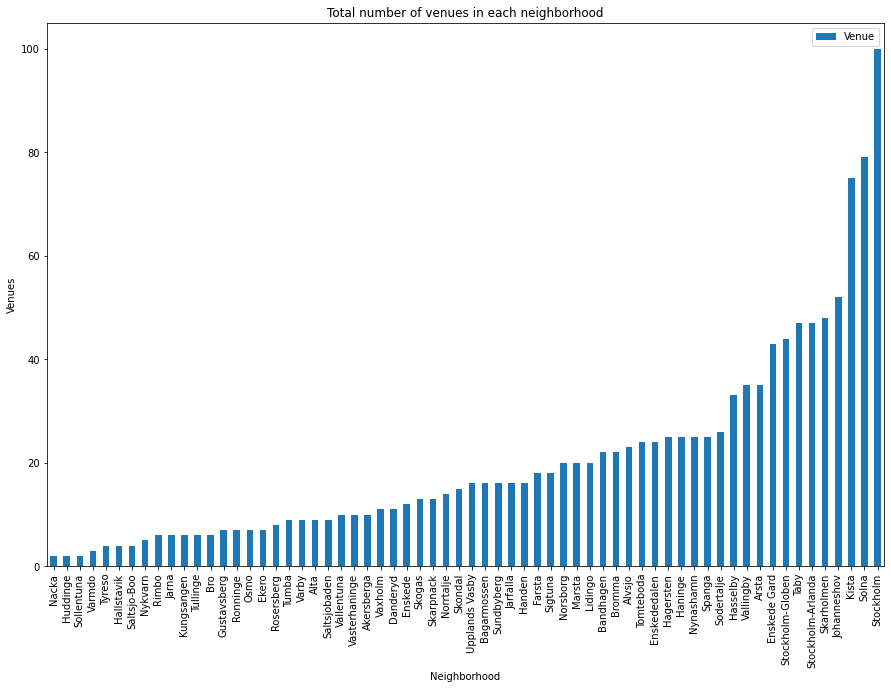

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [15, 10]
st1=Stockholm_food_venues[['Neighborhood', 'Venue']]
st2= st1.groupby('Neighborhood').count()
st3= st2.sort_values(by=['Venue'])
st3.plot.bar(y='Venue')

plt.ylabel('Venues')
plt.title('Total number of venues in each neighborhood')
plt.show()


In [18]:
Stockholm_food_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Akersberga,10,10,10,10,10,10
Alta,9,9,9,9,9,9
Alvsjo,23,23,23,23,23,23
Arsta,35,35,35,35,35,35
Bagarmossen,16,16,16,16,16,16
...,...,...,...,...,...,...
Vallingby,35,35,35,35,35,35
Varby,9,9,9,9,9,9
Varmdo,3,3,3,3,3,3


In [19]:
print('There are {} uniques categories.'.format(len(Stockholm_food_venues['Venue Category'].unique())))
print ('There are {} Food Venues in stockholm'.format(len(Stockholm_food_venues['Venue'])))

There are 203 uniques categories.
There are 1302 Food Venues in stockholm


In [20]:
Stockholm_onehot = pd.get_dummies(Stockholm_food_venues[['Venue Category']], prefix="", prefix_sep="")
Stockholm_onehot['Neighborhood'] = Stockholm_food_venues['Neighborhood'] 
fixed_columns = [Stockholm_onehot.columns[-1]] + list(Stockholm_onehot.columns[:-1])
Stockholm_onehot = Stockholm_onehot[fixed_columns]
Stockholm_onehot.head()

,Women's Store,Airport,Airport Lounge,Airport Service,American Restaurant,Asian Restaurant,Assisted Living,Athletics & Sports,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Badminton Court,Bagel Shop,Bakery,Bar,Basketball Court,Bath House,Beach,Bed & Breakfast,Beer Garden,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Burger Joint,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Camera Store,Campground,Canal Lock,Candy Store,...,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Soccer Field,Soccer Stadium,South Indian Restaurant,Sporting Goods Shop,Stables,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Track,Track Stadium,Trail,Train Station,Tram Station,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Wine Bar
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [21]:
Stockholm_onehot.shape

(1302, 203)

In [22]:
Stockholm_grouped = Stockholm_onehot.groupby('Neighborhood').mean().reset_index()
Stockholm_grouped

,Neighborhood,Women's Store,Airport,Airport Lounge,Airport Service,American Restaurant,Asian Restaurant,Assisted Living,Athletics & Sports,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Badminton Court,Bagel Shop,Bakery,Bar,Basketball Court,Bath House,Beach,Bed & Breakfast,Beer Garden,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Burger Joint,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Camera Store,Campground,Canal Lock,...,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Soccer Field,Soccer Stadium,South Indian Restaurant,Sporting Goods Shop,Stables,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Track,Track Stadium,Trail,Train Station,Tram Station,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Wine Bar
0,Akersberga,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.100000,0.0,0.0,0.0,0.0,0.0,0.0,0.100000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.1,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.1,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Alta,0.0,0.0,0.0,0.0,0.000000,0.111111,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.111111,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.111111,0.0,0.000000,0.111111,0.0,0.0,0.000000,0.0,0.111111,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Alvsjo,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.043478,0.0,0.0,0.0,0.0,0.0,0.0,0.043478,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.086957,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.043478,0.0,0.000000,0.043478,0.0,0.0,0.000000,0.0,0.000000,0.0,0.086957,0.0,0.0,0.0,0.0,0.0,0.000000,0.043478,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.043478,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Arsta,0.0,0.0,0.0,0.0,0.000000,0.028571,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.028571,0.0,0.0,0.000000,0.028571,0.0,0.0,0.000000,0.000000,0.0,0.028571,0.0,0.000000,0.0,0.0,0.028571,0.028571,0.0,0.0,0.0,0.057143,0.0,0.0,0.0,...,0.0,0.0,0.028571,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.057143,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.028571,0.028571,0.0,0.000000,0.0,0.0,0.0,0.000000,0.028571,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Bagarmossen,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.062500,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.062500,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.125000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,Vallingby,0.0,0.0,0.0,0.0,0.028571,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.028571,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.028571,0.0,0.0,0.0,0.057143,0.0,0.0,0.0,...,0.0,0.0,0.028571,0.0,0.0

In [23]:
num_top_venues = 5

for hood in Stockholm_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = Stockholm_grouped[Stockholm_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Akersberga----
                venue  freq
0         Pizza Place   0.1
1  Light Rail Station   0.1
2              Forest   0.1
3        Burger Joint   0.1
4           Gastropub   0.1


----Alta----
               venue  freq
0  Convenience Store  0.11
1      Grocery Store  0.11
2        Pizza Place  0.11
3            Stadium  0.11
4       Soccer Field  0.11


----Alvsjo----
                  venue  freq
0                 Hotel  0.13
1           Supermarket  0.09
2                  Café  0.09
3  Fast Food Restaurant  0.04
4          Soccer Field  0.04


----Arsta----
               venue  freq
0  Convenience Store  0.06
1        Pizza Place  0.06
2      Grocery Store  0.06
3               Café  0.06
4       Soccer Field  0.06


----Bagarmossen----
                  venue  freq
0           Pizza Place  0.25
1           Supermarket  0.12
2         Metro Station  0.12
3  Fast Food Restaurant  0.12
4                  Park  0.06


----Bandhagen----
                  venue  freq
0        

In [24]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [25]:
num_top_venues = 10
indicators = ['st', 'nd', 'rd']
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Stockholm_grouped['Neighborhood']

for ind in np.arange(Stockholm_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Stockholm_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(30)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Akersberga,Pizza Place,Athletics & Sports,Forest,Liquor Store,Sushi Restaurant,Light Rail Station,Gastropub,Grocery Store,Bakery,Burger Joint
1,Alta,Pizza Place,Convenience Store,Shopping Mall,Asian Restaurant,Stadium,Grocery Store,Supermarket,Bus Stop,Soccer Field,Farm
2,Alvsjo,Hotel,Café,Supermarket,Soccer Field,Pizza Place,Shopping Mall,Fast Food Restaurant,Forest,Restaurant,Tennis Stadium
3,Arsta,Pizza Place,Convenience Store,Soccer Field,Flower Shop,Grocery Store,Café,Field,Fast Food Restaurant,Scandinavian Restaurant,Bus Stop
4,Bagarmossen,Pizza Place,Metro Station,Fast Food Restaurant,Supermarket,Bakery,Café,Japanese Restaurant,Other Great Outdoors,Grocery Store,Park
5,Bandhagen,Convenience Store,Gym / Fitness Center,Grocery Store,Sushi Restaurant,Pizza Place,Metro Station,Pet Store,Playground,Café,Scandinavian Restaurant
6,Bro,Pizza Place,Convenience Store,Bus Station,Train Station,Gym Pool,Grocery Store,Event Space,Flower Shop,Flea Market,Fish Market
7,Bromma,Supermarket,Sushi Restaurant,Soccer Field,Tennis Court,Pizza Place,Chinese Restaurant,Pub,Café,Fast Food Restaurant,Bus Stop
8,Danderyd,Pizza Place,Bus Station,Gym / Fitness Center,Supermarket,Grocery Store,Auto Workshop,Burger Joint,Hotel,Hobby Shop,Design Studio
9,Ekero,Pizza Place,Convenience Store,Stadium,Gym / Fitness Center,Grocery Store,Restaurant,Electronics Store,Flea Market,Fish Market,Field


In [26]:
Stockholm_grouped_clustring= Stockholm_grouped.drop('Neighborhood', 1)
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(Stockholm_grouped_clustring)
    Sum_of_squared_distances.append(km.inertia_)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fd248ce0128>,
                 k=None, metric=None, model=None, timings=True)

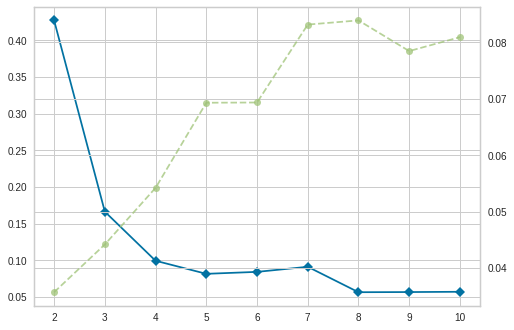

In [27]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
model = KElbowVisualizer(KMeans(), k=10, metric='silhouette', locate_elbow=True)
model.fit(Stockholm_grouped_clustring)

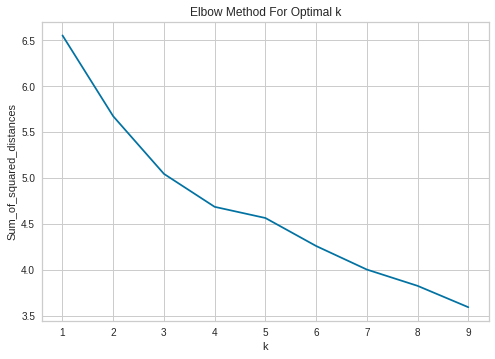

In [28]:
import matplotlib.pyplot as plt
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [29]:
kclusters = 4
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Stockholm_grouped_clustring)
kmeans.labels_[0:10]

array([3, 1, 3, 3, 1, 1, 1, 3, 1, 1], dtype=int32)

In [30]:

neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Stockholm_merged = Stockholm_geo_data

Stockholm_merged = Stockholm_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
Stockholm_merged.drop([16], inplace=True)
Stockholm_merged.reset_index()

Stockholm_merged

,Neighborhood,Latitude,Longitude,Population,Postal_Code,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Akersberga,59.4803,18.3108,28033,[184 20],3,Pizza Place,Athletics & Sports,Forest,Liquor Store,Sushi Restaurant,Light Rail Station,Gastropub,Grocery Store,Bakery,Burger Joint
1,Alta,59.2555,18.1781,9989,[138 20],1,Pizza Place,Convenience Store,Shopping Mall,Asian Restaurant,Stadium,Grocery Store,Supermarket,Bus Stop,Soccer Field,Farm
2,Alvsjo,59.2745,18.0051,1530,"[125 00, 125 58, 125 52, 125 53, 125 54, 125 5...",3,Hotel,Café,Supermarket,Soccer Field,Pizza Place,Shopping Mall,Fast Food Restaurant,Forest,Restaurant,Tennis Stadium
3,Arsta,59.2986,18.0459,16807,"[120 02, 120 52, 120 59, 120 58, 120 57, 120 5...",3,Pizza Place,Convenience Store,Soccer Field,Flower Shop,Grocery Store,Café,Field,Fast Food Restaurant,Scandinavian Restaurant,Bus Stop
4,Bagarmossen,59.2744,18.1338,10915,"[128 04, 128 05, 128 41, 128 42, 128 43, 128 4...",1,Pizza Place,Metro Station,Fast Food Restaurant,Supermarket,Bakery,Café,Japanese Restaurant,Other Great Outdoors,Grocery Store,Park
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,Vallingby,59.3671,17.8691,82500,"[162 00, 162 60, 162 01, 162 88, 162 83, 162 7...",3,Supermarket,Café,Clothing Store,Gym / Fitness Center,Department Store,Fast Food Restaurant,Metro Station,Pet Store,Bookstore,Shopping Mall
60,Varby,59.2635,17.8876,10727,"[143 46, 143 20]",1,Pizza Place,Grocery Store,Fast Food Restaurant,Bus Station,Brewery,Metro Station,Furniture / Home Store,Convenience Store,Gym Pool,Gym / Fitness Center
61,Varmdo,59.2846,18.5208,45393,"[139 00, 139 20, 139 31]",2,Beach,Tennis Court,Lake,Wine Bar,Farm,Food & Drink Shop,Food,Flower Shop,Flea Market,Fish Market
62,Vasterhaninge,59.1216,18.0973,15134,"[137 20, 137 42]",1,Grocery Store,Restaurant,Pizza Place,Bus Station,Train Station,Stadium,Supermarket,Liquor Store,Café,Falafel Restaurant


In [31]:
Stockholm_merged.loc[Stockholm_merged['Cluster Labels'] == 0, Stockholm_merged.columns[[0] + list(range(5, Stockholm_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
28,Nacka,0,Lake,Grocery Store,Wine Bar,Food & Drink Shop,Food,Flower Shop,Flea Market,Fish Market,Field,Fast Food Restaurant
45,Sollentuna,0,Train Station,Grocery Store,Wine Bar,Electronics Store,Food,Flower Shop,Flea Market,Fish Market,Field,Fast Food Restaurant


In [32]:
cluster1 = Stockholm_merged.loc[Stockholm_merged['Cluster Labels'] == 0, Stockholm_merged.columns[[0] + 
                                                                                    list(range(4, Stockholm_merged.shape[1]))]]
venues1 = (cluster1['1st Most Common Venue'].append(
    cluster1['2nd Most Common Venue']).append(
    cluster1['3rd Most Common Venue']).append(
    cluster1['4th Most Common Venue']).append(
    cluster1['5th Most Common Venue']).append(
    cluster1['6th Most Common Venue']).append(
    cluster1['7th Most Common Venue']).append(
    cluster1['8th Most Common Venue']).append(
    cluster1['9th Most Common Venue']).append(
    cluster1['10th Most Common Venue']))

print(venues1.value_counts().head(10))

Flower Shop             2
Field                   2
Flea Market             2
Wine Bar                2
Food                    2
Grocery Store           2
Fast Food Restaurant    2
Fish Market             2
Train Station           1
Food & Drink Shop       1
dtype: int64


In [33]:
Stockholm_merged.loc[Stockholm_merged['Cluster Labels'] == 1, Stockholm_merged.columns[[0] + list(range(5, Stockholm_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Alta,1,Pizza Place,Convenience Store,Shopping Mall,Asian Restaurant,Stadium,Grocery Store,Supermarket,Bus Stop,Soccer Field,Farm
4,Bagarmossen,1,Pizza Place,Metro Station,Fast Food Restaurant,Supermarket,Bakery,Café,Japanese Restaurant,Other Great Outdoors,Grocery Store,Park
5,Bandhagen,1,Convenience Store,Gym / Fitness Center,Grocery Store,Sushi Restaurant,Pizza Place,Metro Station,Pet Store,Playground,Café,Scandinavian Restaurant
6,Bro,1,Pizza Place,Convenience Store,Bus Station,Train Station,Gym Pool,Grocery Store,Event Space,Flower Shop,Flea Market,Fish Market
8,Danderyd,1,Pizza Place,Bus Station,Gym / Fitness Center,Supermarket,Grocery Store,Auto Workshop,Burger Joint,Hotel,Hobby Shop,Design Studio
9,Ekero,1,Pizza Place,Convenience Store,Stadium,Gym / Fitness Center,Grocery Store,Restaurant,Electronics Store,Flea Market,Fish Market,Field
10,Enskede,1,Pizza Place,Hobby Shop,Supermarket,Metro Station,Park,Café,Bus Station,Bus Stop,Grocery Store,Sushi Restaurant
13,Farsta,1,Grocery Store,Metro Station,Bakery,Shopping Plaza,Coffee Shop,Farm,Thai Restaurant,Theater,Plaza,Restaurant
22,Jarna,1,Pizza Place,Train Station,Music Venue,Supermarket,Grocery Store,Coffee Shop,Gym Pool,Eastern European Restaurant,Fish Market,Field
25,Kungsangen,1,Pharmacy,Train Station,Supermarket,Grocery Store,Liquor Store,Café,Wine Bar,Falafel Restaurant,Flower Shop,Flea Market


In [34]:
cluster2 = Stockholm_merged.loc[Stockholm_merged['Cluster Labels'] == 1, Stockholm_merged.columns[[0] + 
                                                                                    list(range(4, Stockholm_merged.shape[1]))]]
venues2 = (cluster2['1st Most Common Venue'].append(
    cluster2['2nd Most Common Venue']).append(
    cluster2['3rd Most Common Venue']).append(
    cluster2['4th Most Common Venue']).append(
    cluster2['5th Most Common Venue']).append(
    cluster2['6th Most Common Venue']).append(
    cluster2['7th Most Common Venue']).append(
    cluster2['8th Most Common Venue']).append(
    cluster2['9th Most Common Venue']).append(
    cluster2['10th Most Common Venue']))

print(venues2.value_counts().head(10))

Grocery Store        21
Pizza Place          13
Supermarket          12
Bus Station          11
Convenience Store     9
Train Station         9
Metro Station         8
Café                  7
Flea Market           6
Flower Shop           6
dtype: int64


In [35]:
Stockholm_merged.loc[Stockholm_merged['Cluster Labels'] == 2, Stockholm_merged.columns[[0] + list(range(5, Stockholm_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,Huddinge,2,Beach,Lake,Wine Bar,Food Truck,Food & Drink Shop,Food,Flower Shop,Flea Market,Fish Market,Field
61,Varmdo,2,Beach,Tennis Court,Lake,Wine Bar,Farm,Food & Drink Shop,Food,Flower Shop,Flea Market,Fish Market


In [36]:
cluster3 = Stockholm_merged.loc[Stockholm_merged['Cluster Labels'] == 2, Stockholm_merged.columns[[0] + 
                                                                                    list(range(4, Stockholm_merged.shape[1]))]]
venues3 = (cluster3['1st Most Common Venue'].append(
    cluster3['2nd Most Common Venue']).append(
    cluster3['3rd Most Common Venue']).append(
    cluster3['4th Most Common Venue']).append(
    cluster3['5th Most Common Venue']).append(
    cluster3['6th Most Common Venue']).append(
    cluster3['7th Most Common Venue']).append(
    cluster3['8th Most Common Venue']).append(
    cluster3['9th Most Common Venue']).append(
    cluster3['10th Most Common Venue']))

print(venues3.value_counts().head(10))

Fish Market          2
Wine Bar             2
Food & Drink Shop    2
Lake                 2
Flea Market          2
Flower Shop          2
Food                 2
Beach                2
Tennis Court         1
Food Truck           1
dtype: int64


In [37]:
Stockholm_merged.loc[Stockholm_merged['Cluster Labels'] == 3, Stockholm_merged.columns[[0] + list(range(5, Stockholm_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Akersberga,3,Pizza Place,Athletics & Sports,Forest,Liquor Store,Sushi Restaurant,Light Rail Station,Gastropub,Grocery Store,Bakery,Burger Joint
2,Alvsjo,3,Hotel,Café,Supermarket,Soccer Field,Pizza Place,Shopping Mall,Fast Food Restaurant,Forest,Restaurant,Tennis Stadium
3,Arsta,3,Pizza Place,Convenience Store,Soccer Field,Flower Shop,Grocery Store,Café,Field,Fast Food Restaurant,Scandinavian Restaurant,Bus Stop
7,Bromma,3,Supermarket,Sushi Restaurant,Soccer Field,Tennis Court,Pizza Place,Chinese Restaurant,Pub,Café,Fast Food Restaurant,Bus Stop
11,Enskede Gard,3,Stadium,Thai Restaurant,Restaurant,Gym / Fitness Center,Bakery,Park,Metro Station,Nightclub,Bus Station,Scenic Lookout
12,Enskededalen,3,Grocery Store,Café,Bakery,Cemetery,Indian Restaurant,Sushi Restaurant,Plaza,Tennis Court,Thai Restaurant,Indie Theater
14,Gustavsberg,3,Flower Shop,Shopping Mall,Department Store,Asian Restaurant,Bus Stop,Furniture / Home Store,Grocery Store,Wine Bar,Falafel Restaurant,Flea Market
15,Hagersten,3,Metro Station,Grocery Store,Pizza Place,Café,Convenience Store,Gym / Fitness Center,Supermarket,Asian Restaurant,Greek Restaurant,Scandinavian Restaurant
17,Handen,3,Bus Station,Middle Eastern Restaurant,Athletics & Sports,Music Venue,Fast Food Restaurant,Electronics Store,Nature Preserve,Shopping Mall,Park,Gym / Fitness Center
18,Haninge,3,Supermarket,Department Store,Gym / Fitness Center,Burger Joint,Shopping Mall,Furniture / Home Store,Liquor Store,Fast Food Restaurant,Bowling Alley,Italian Restaurant


In [38]:
cluster4 = Stockholm_merged.loc[Stockholm_merged['Cluster Labels'] == 3, Stockholm_merged.columns[[0] + 
                                                                                    list(range(4, Stockholm_merged.shape[1]))]]
venues4 = (cluster4['1st Most Common Venue'].append(
    cluster4['2nd Most Common Venue']).append(
    cluster4['3rd Most Common Venue']).append(
    cluster4['4th Most Common Venue']).append(
    cluster4['5th Most Common Venue']).append(
    cluster4['6th Most Common Venue']).append(
    cluster4['7th Most Common Venue']).append(
    cluster4['8th Most Common Venue']).append(
    cluster4['9th Most Common Venue']).append(
    cluster4['10th Most Common Venue']))

print(venues4.value_counts().head(10))

Café                       18
Gym / Fitness Center       16
Fast Food Restaurant       14
Pizza Place                14
Scandinavian Restaurant    12
Grocery Store              12
Asian Restaurant           10
Supermarket                10
Shopping Mall              10
Soccer Field                9
dtype: int64


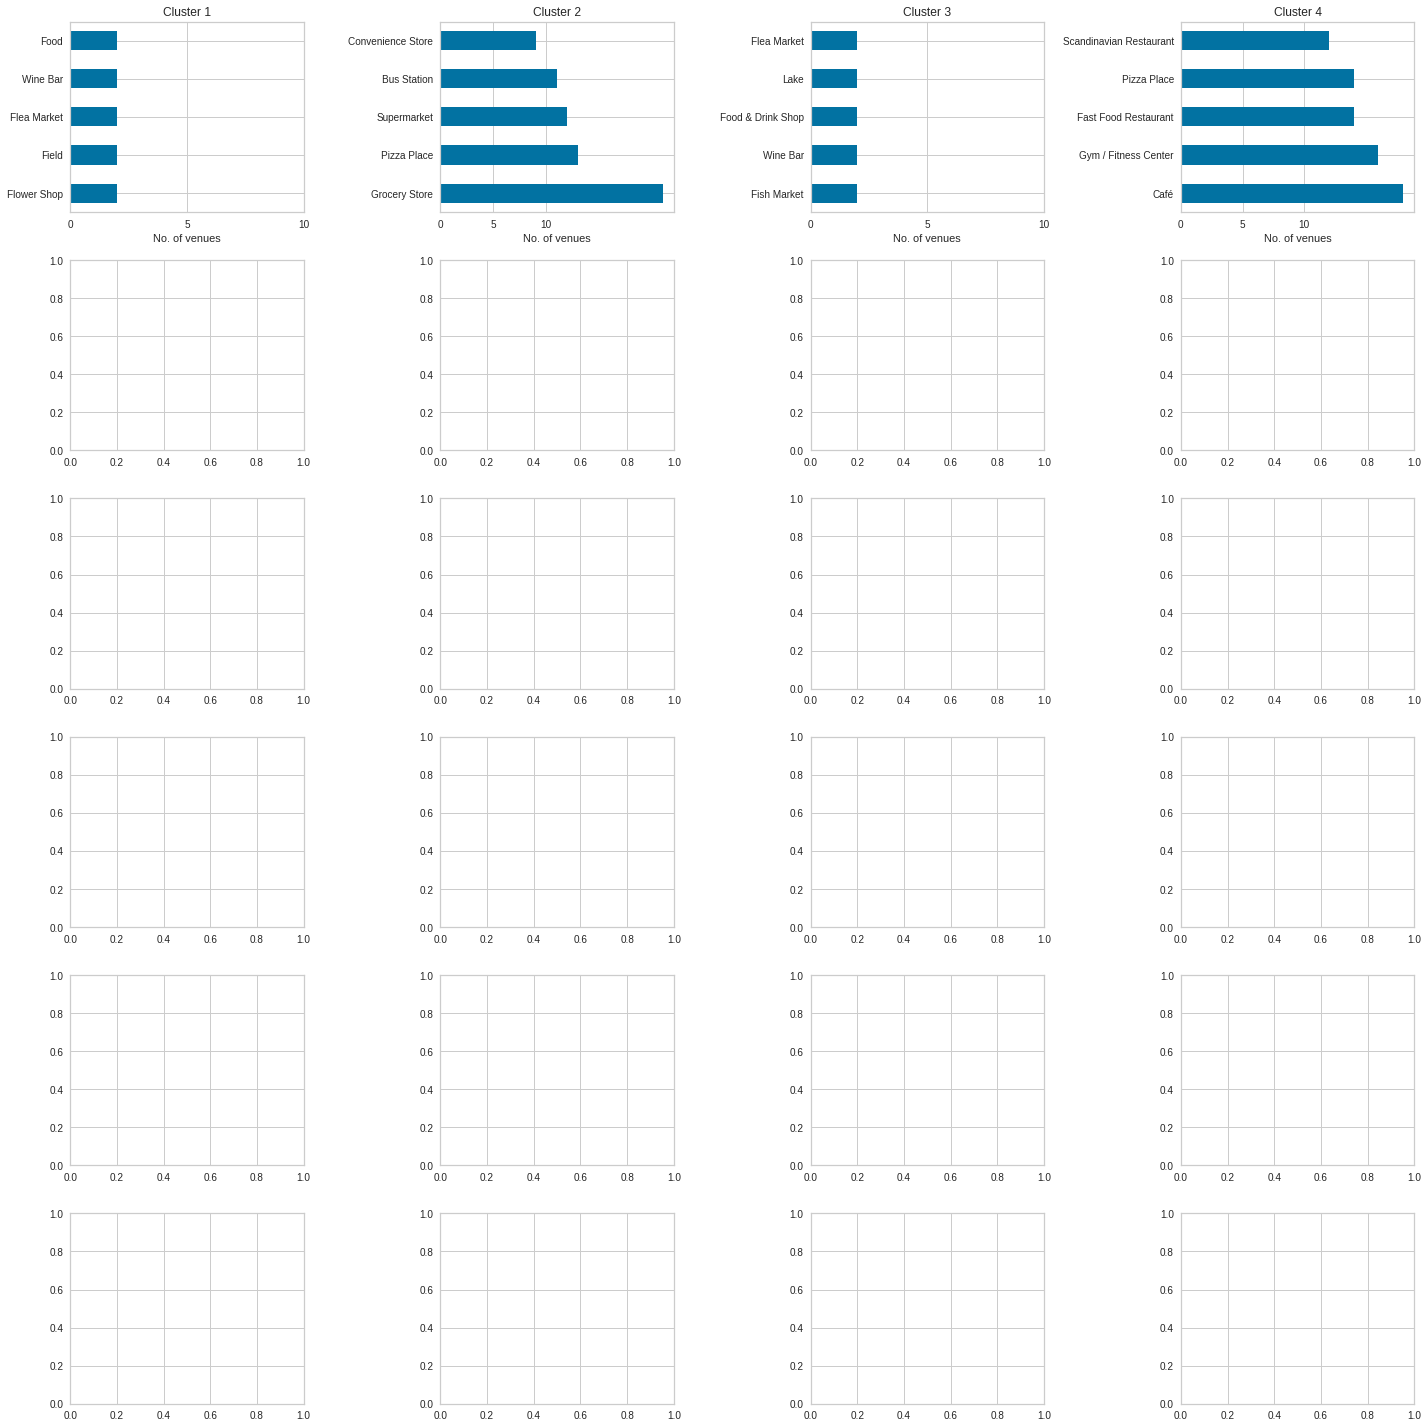

In [39]:
df_list = [venues1 ,venues2, venues3, venues4]
fig, axes = plt.subplots(6, 4)

count = 0
for r in range(6):
    for c in range(4):
        df_list[count].value_counts().head().plot.barh(ax = axes[r,c], width=0.5, figsize=(20,20))
        axes[r,c].set_title('Cluster {}'.format(count+1))
        plt.sca(axes[r, c])
        plt.xticks(np.arange(0, 15, 5))
        plt.xlabel('No. of venues')
        count += 1
    if count== 4:
       break


fig.tight_layout()

In [40]:
def addToMap(df, color, existingMap):
    for lat, lng, local, venue, venueCat in zip(df['Venue Latitude'], df['Venue Longitude'], df['Neighborhood'], df['Venue'], df['Venue Category']):
        label = '{} ({}) - {}'.format(venue, venueCat, local)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.7).add_to(existingMap)

In [41]:
map_Stockholm_food_venues = folium.Map(location=[latitude, longitude], zoom_start=10)
addToMap(Stockholm_food_venues, 'red', map_Stockholm_food_venues)

map_Stockholm_food_venues

In [42]:
Stockholm_grouped_1=  Stockholm_food_venues.groupby('Neighborhood').count()
Stockholm_grouped_1.head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Akersberga,10,10,10,10,10,10
Alta,9,9,9,9,9,9
Alvsjo,23,23,23,23,23,23
Arsta,35,35,35,35,35,35
Bagarmossen,16,16,16,16,16,16


In [43]:
Stockholm_grouped_1.shape

(64, 6)

In [44]:
Data_1= pd.DataFrame(data=Stockholm_grouped_1, columns=['Venue'] )
Data_1

,Venue
Neighborhood,
Akersberga,10
Alta,9
Alvsjo,23
Arsta,35
Bagarmossen,16
...,...
Vallingby,35
Varby,9
Varmdo,3


In [45]:
Stockholm= pd.merge(Stockholm_geo_data , Data_1, on='Neighborhood')

In [46]:
Stockholm

,Neighborhood,Latitude,Longitude,Population,Postal_Code,Venue
0,Akersberga,59.4803,18.3108,28033,[184 20],10
1,Alta,59.2555,18.1781,9989,[138 20],9
2,Alvsjo,59.2745,18.0051,1530,"[125 00, 125 58, 125 52, 125 53, 125 54, 125 5...",23
3,Arsta,59.2986,18.0459,16807,"[120 02, 120 52, 120 59, 120 58, 120 57, 120 5...",35
4,Bagarmossen,59.2744,18.1338,10915,"[128 04, 128 05, 128 41, 128 42, 128 43, 128 4...",16
...,...,...,...,...,...,...
59,Vallingby,59.3671,17.8691,82500,"[162 00, 162 60, 162 01, 162 88, 162 83, 162 7...",35
60,Varby,59.2635,17.8876,10727,"[143 46, 143 20]",9
61,Varmdo,59.2846,18.5208,45393,"[139 00, 139 20, 139 31]",3
62,Vasterhaninge,59.1216,18.0973,15134,"[137 20, 137 42]",10


In [47]:
Stockholm_1=pd.DataFrame(data= Stockholm, columns= ['Neighborhood', 'Density'])
Stockholm_1

,Neighborhood,Density
0,Akersberga,NaN
1,Alta,NaN
2,Alvsjo,NaN
3,Arsta,NaN
4,Bagarmossen,NaN
...,...,...
59,Vallingby,NaN
60,Varby,NaN
61,Varmdo,NaN
62,Vasterhaninge,NaN


In [48]:
Stockholm_1['Density']= Stockholm['Venue']/Stockholm['Population ']

In [49]:
Stockholm_1.head()

,Neighborhood,Density
0,Akersberga,0.000357
1,Alta,0.000901
2,Alvsjo,0.015033
3,Arsta,0.002082
4,Bagarmossen,0.001466


In [50]:
Stockholm_1=Stockholm_1.sort_values(by= ['Density'])
pd.set_option("max_rows", None)
Stockholm_1

,Neighborhood,Density
20,Huddinge,0.000018
28,Nacka,0.000019
45,Sollentuna,0.000027
61,Varmdo,0.000066
56,Tyreso,0.000082
48,Stockholm,0.000102
10,Enskede,0.000124
37,Saltsjo-Boo,0.000166
21,Jarfalla,0.000197
29,Norrtalje,0.000220


#*RESULTS*
As showen above, there is a huge disparity in the supply levels across Stockholm. Some neighborhoods might benfite immidiatly from opining any food venues in it.  Huddinge,	Nacka and Sollentuna rank as least coverd neighborhoods. Further investigation will help in understand the need of each neighborhood; the type of food venues might differ according to the need of the respective neighborhood. 
   
  